In [68]:
# Instalar bibliotecas necesarias
!pip install gensim tensorflow

# Importar bibliotecas
from gensim.models import KeyedVectors
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Nombre del archivo descargado
nombre_archivo = "/content/GoogleNews-vectors-negative300.bin"

# Cargar el archivo con KeyedVectors con un límite
word2vec_model_google = KeyedVectors.load_word2vec_format(nombre_archivo, binary=True)

# Mostrar las primeras 10 palabras del modelo
print("Las primeras 10 palabras del modelo son:", list(word2vec_model_google.index_to_key)[:10])


FileNotFoundError: [Errno 2] No such file or directory: '/content/GoogleNews-vectors-negative300.bin'



```
2. Para nuestro análisis usaremos un Word Embedding ya entrenado, en particular
utilizaremos word2Vec entrenado con corpus Google News con 3 millones de
palabras, cada una representada con 300 dimensiones. Para esto, carga Word
Embedding de Google como se muestra a continuación

```





```
1. Carga la base de datos news1.csv y realiza un conteo por clase (columna label).
Divide el conjunto de datos en entrenamiento y test (33%) y realiza una exploración
de frecuencias de palabras.
```



In [15]:
# Importar bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar los datos de entrenamiento
df = pd.read_csv("/content/news1.csv", on_bad_lines='skip', engine='python')

# Filtrar solo las filas con etiquetas 'REAL' o 'FAKE'
df = df[df["label"].isin(["REAL", "FAKE"])]

# Mapear labels a enteros
label_mapping = {"REAL": 1, "FAKE": 0}
df["label"] = df["label"].map(label_mapping)

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.33, random_state=42
)

# Convertir y_train y y_test a arrays de NumPy de tipo entero
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

# Convertir todos los textos a cadenas de texto y llenar valores faltantes
X_train = X_train.apply(lambda x: str(x)).fillna("")
X_test = X_test.apply(lambda x: str(x)).fillna("")





```
Tokeniza las palabras del conjunto de entrenamiento con un máximo de 80.000
palabras para el vocabulario, y realiza padding para cada secuencia con largo
máximo de 80. Finalmente, crea la matriz de embedding usando el Word2Vec pre
entrenado.

```



In [16]:
# Exploración de frecuencias de palabras
tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(X_train)

# Obtener frecuencias de palabras
word_freq = tokenizer.word_counts
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_words[:20]
print("Top 20 palabras más frecuentes:", top_words)

# Convertir textos a secuencias y aplicar padding
max_length = 80
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)

Top 20 palabras más frecuentes: [('the', 91554), ('to', 43831), ('of', 41457), ('and', 37649), ('a', 33795), ('in', 31203), ('that', 22270), ('is', 17065), ('for', 14289), ('on', 12757), ('as', 10220), ('it', 9877), ('with', 9524), ('he', 8806), ('was', 8458), ('this', 8144), ('are', 8046), ('be', 7975), ('by', 7786), ('have', 7675)]


In [17]:
# Crear la matriz de embedding usando el modelo Word2Vec preentrenado
embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i >= 80000:
        continue
    try:
        embedding_vector = word2vec_model_google[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass



```
3. Implementa un modelo de red neuronal recurrente LSTM, con un mínimo de tres
capas, empleando regularización Dropout. (Considera la capa de Embedding con los pesos pre-entrenados). El modelo debe lograr un accuracy superior al 80% y la
cantidad de épocas no debe superar las 20. Muestra las métricas apropiadas para
medir el rendimiento del modelo, incluyendo la curva ROC.

```



In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
model = Sequential()
model.add(
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,
    )
)
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="sigmoid"))

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Entrenar el modelo
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
history = model.fit(
    X_train_seq,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/20
29/29 [==============================] - 17s 449ms/step - loss: 0.1899 - accuracy: 0.0000e+00 - val_loss: -0.1492 - val_accuracy: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 12s 412ms/step - loss: 0.1635 - accuracy: 0.0000e+00 - val_loss: -0.1069 - val_accuracy: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 12s 410ms/step - loss: 0.1440 - accuracy: 0.0000e+00 - val_loss: -0.1098 - val_accuracy: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 12s 420ms/step - loss: 0.1645 - accuracy: 0.0000e+00 - val_loss: -0.0896 - val_accuracy: 0.0000e+00


ValueError: Data cardinality is ambiguous:
  x sizes: 1013
  y sizes: 8370
Make sure all arrays contain the same number of samples.

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Predecir probabilidades para el conjunto de prueba
y_pred_prob = model.predict(X_test_seq)

# Calcular el AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc}")

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Predecir etiquetas para el conjunto de prueba
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calcular y mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

# Mostrar el reporte de clasificación
print("Classification Report")
print(classification_report(y_test, y_pred))


32/32 [==============================] - 4s 111ms/step


ValueError: continuous format is not supported

In [20]:
# Cargar el archivo de predicciones
df_pred = pd.read_csv("/content/news_pred.csv")

# Tokenizar y aplicar padding a las noticias de predicción
X_pred = df_pred["text"].apply(lambda x: str(x)).fillna("")
X_pred_seq = pad_sequences(tokenizer.texts_to_sequences(X_pred), maxlen=max_length)

# Realizar predicciones
y_pred = model.predict(X_pred_seq)
y_pred_labels = (y_pred > 0.5).astype(int)

# Mapear los labels de vuelta a texto
label_mapping_inv = {1: "REAL", 0: "FAKE"}
df_pred["predicted_label"] = y_pred_labels
df_pred["predicted_label"] = df_pred["predicted_label"].map(label_mapping_inv)

# Mostrar los resultados
print(df_pred[["text", "predicted_label"]])

1/1 [==============================] - 1s 1s/step
                                                text predicted_label
0  Gunmen stormed the offices of the satirical ne...            FAKE
1  World leaders' personal chefs sample Indian ma...            FAKE
2  Tweet Widget by Black Power Front \nWith stude...            FAKE
3  Gay man finds it in himself to tolerate religi...            FAKE
4  Get short URL 0 27 0 0 On Tuesday, National In...            REAL
5  More Floods, More Drought Inevitable. How Bad ...            FAKE
6  President Obama’s executive action sparing mil...            REAL


In [21]:
# Verificar si hay alguna predicción incorrecta
# En este caso, no tenemos las etiquetas verdaderas para comparar, así que revisaremos los resultados manualmente
incorrect_prediction = df_pred[df_pred["predicted_label"] != df_pred["label"]]

if not incorrect_prediction.empty:
    print("Predicciones incorrectas encontradas:")
    print(incorrect_prediction[["text", "label", "predicted_label"]])
else:
    print("No se encontraron predicciones incorrectas.")

Predicciones incorrectas encontradas:
                                                text label predicted_label
0  Gunmen stormed the offices of the satirical ne...  REAL            FAKE
4  Get short URL 0 27 0 0 On Tuesday, National In...  FAKE            REAL
5  More Floods, More Drought Inevitable. How Bad ...  REAL            FAKE


In [22]:
# Cargar la base de datos de artículos publicados por Mashable
df_mashable = pd.read_csv("OnlineNewsPopularity.csv")

# Quitar los espacios en blanco de los nombres de las columnas
df_mashable.columns = df_mashable.columns.str.strip()

# Eliminar columnas que no aporten información relevante
df_mashable.drop(columns=["url"], inplace=True)

# Revisar valores ausentes
missing_values = df_mashable.isnull().sum()
print("Valores ausentes por columna:")
print(missing_values[missing_values > 0])

# Si existen valores ausentes, decidir qué hacer (en este caso, eliminaremos filas con valores ausentes)
df_mashable.dropna(inplace=True)

# Calcular indicadores estadísticos principales para las variables numéricas
stats = df_mashable.describe()
print("Indicadores estadísticos principales:")
print(stats)

Valores ausentes por columna:
max_negative_polarity           1
title_subjectivity              1
title_sentiment_polarity        1
abs_title_subjectivity          1
abs_title_sentiment_polarity    1
shares                          1
dtype: int64
Indicadores estadísticos principales:
          timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
count  25620.000000    25620.000000      25620.000000     25620.000000   
mean     483.392428       10.085480        534.913232         0.548501   
std      147.801039        2.014941        465.870856         0.118410   
min      232.000000        2.000000          0.000000         0.000000   
25%      351.000000        9.000000        241.000000         0.479866   
50%      484.000000       10.000000        394.000000         0.550119   
75%      612.000000       11.000000        690.000000         0.620112   
max      731.000000       19.000000       8474.000000         1.000000   

       n_non_stop_words  n_non_stop_unique_token

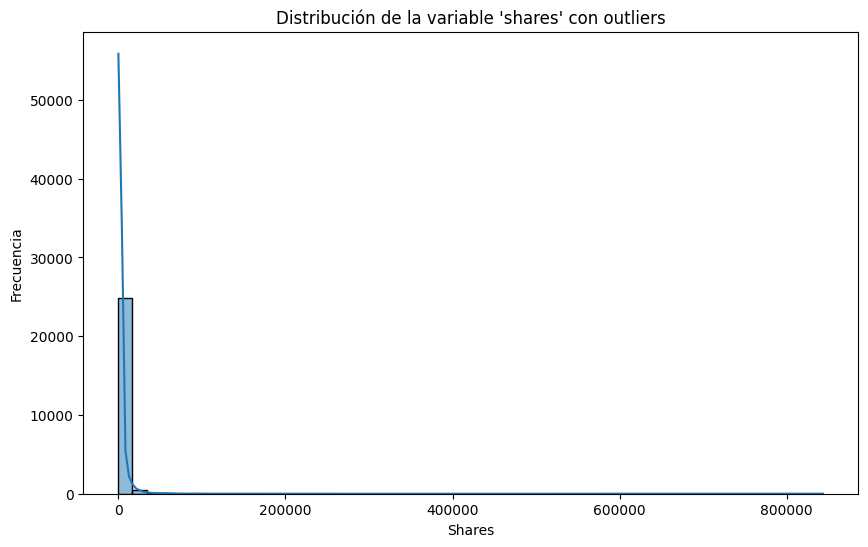

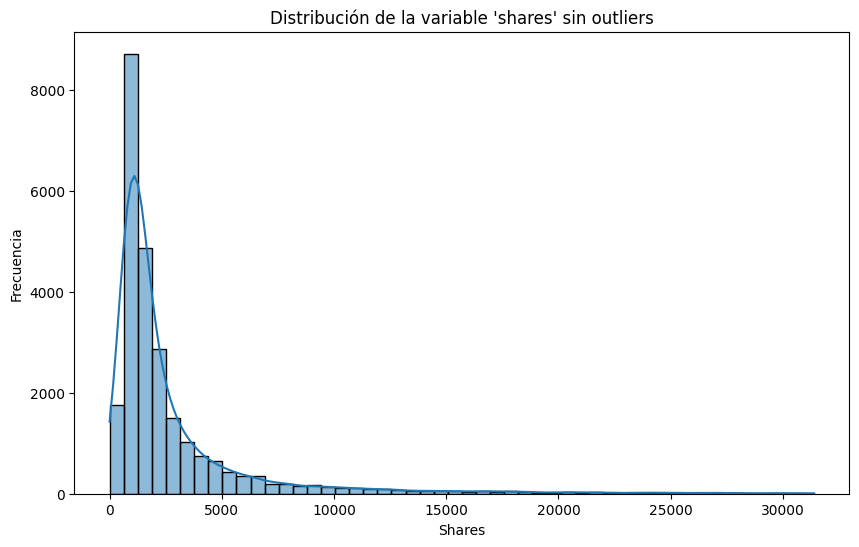

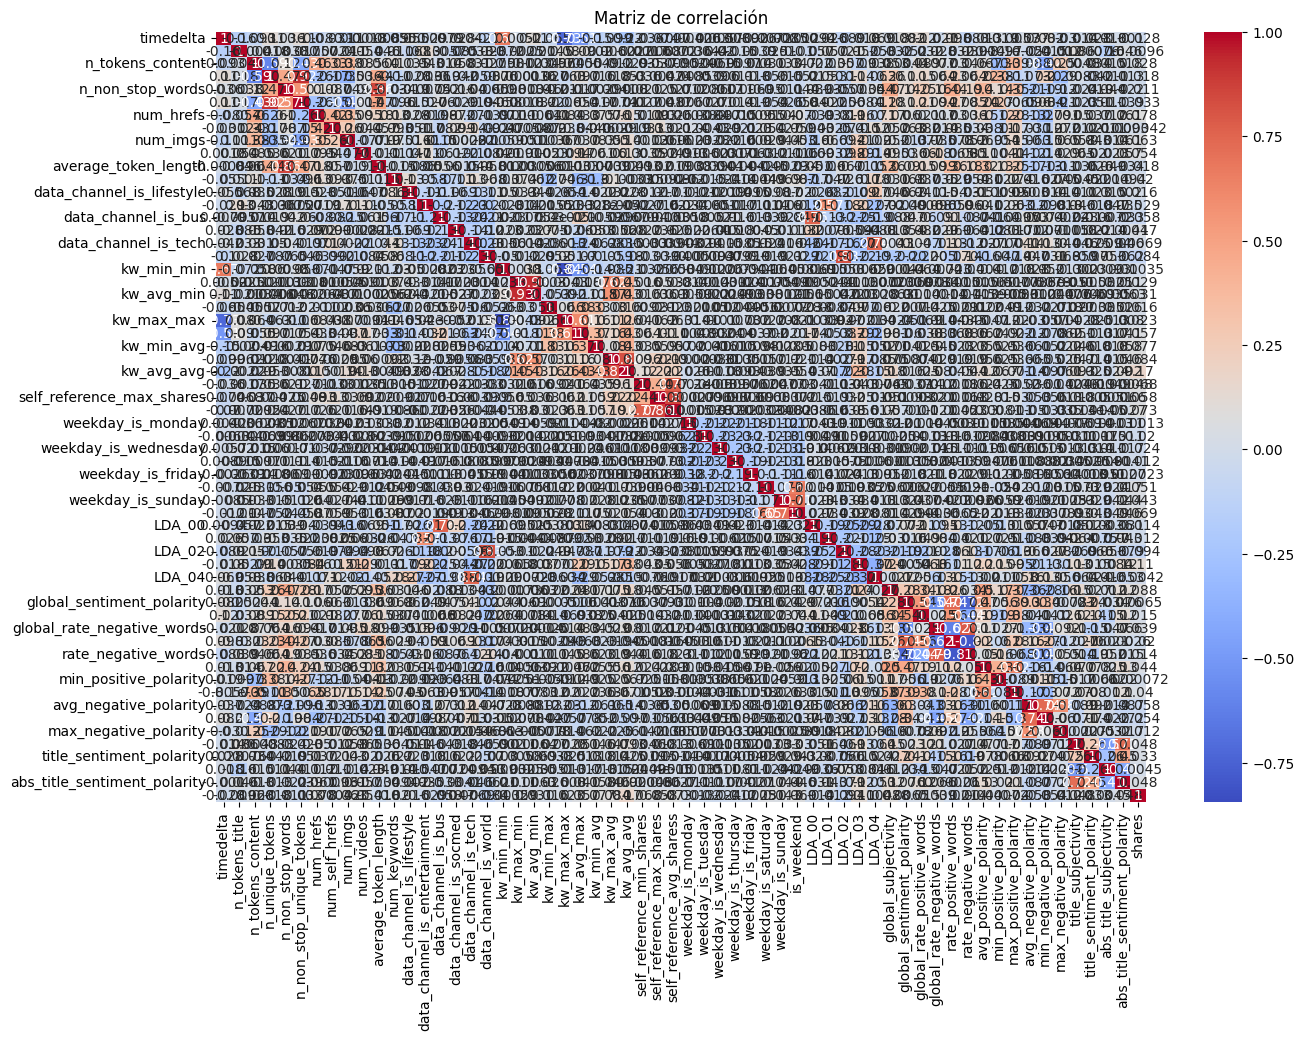

Pares de variables con correlaciones altas:
kw_avg_min                    kw_max_min                      0.934488
kw_max_min                    kw_avg_min                      0.934488
n_non_stop_unique_tokens      n_unique_tokens                 0.915156
n_unique_tokens               n_non_stop_unique_tokens        0.915156
self_reference_max_shares     self_reference_avg_sharess      0.862409
self_reference_avg_sharess    self_reference_max_shares       0.862409
average_token_length          n_non_stop_words                0.861163
n_non_stop_words              average_token_length            0.861163
kw_max_max                    kw_min_min                      0.843656
kw_min_min                    kw_max_max                      0.843656
data_channel_is_world         LDA_02                          0.827026
LDA_02                        data_channel_is_world           0.827026
kw_avg_avg                    kw_max_avg                      0.824956
kw_max_avg                    kw_

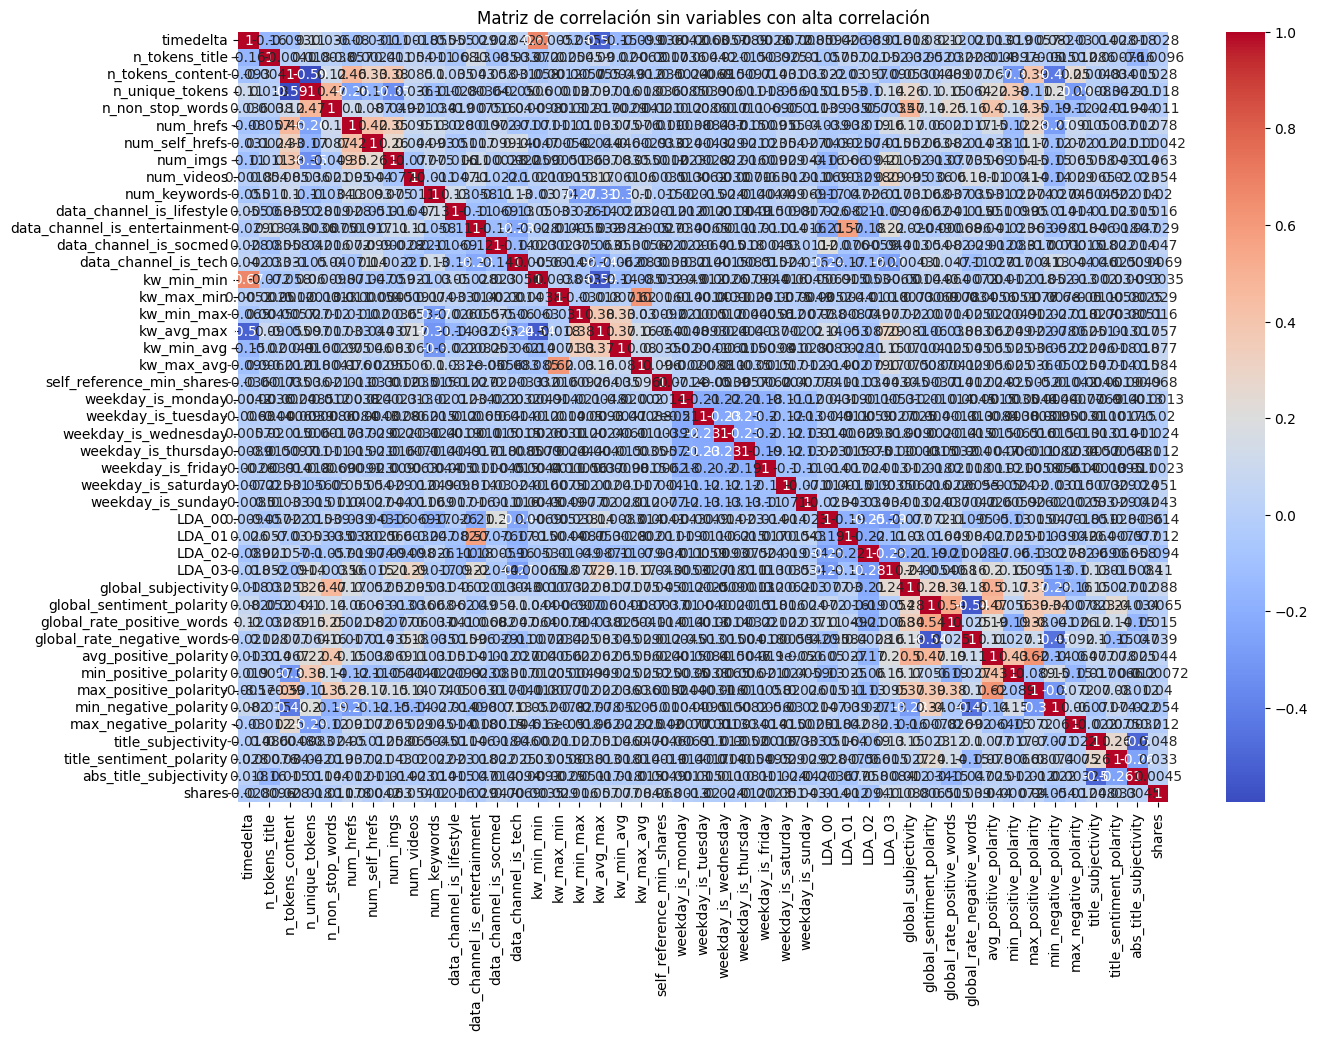

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar la distribución de la variable objetivo "shares" con outliers
plt.figure(figsize=(10, 6))
sns.histplot(df_mashable["shares"], bins=50, kde=True)
plt.title("Distribución de la variable 'shares' con outliers")
plt.xlabel("Shares")
plt.ylabel("Frecuencia")
plt.show()

# Eliminar outliers (consideraremos valores mayores al percentil 99 como outliers)
percentile_99 = df_mashable["shares"].quantile(0.99)
df_mashable_no_outliers = df_mashable[df_mashable["shares"] <= percentile_99]

# Mostrar la distribución de la variable objetivo "shares" sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(df_mashable_no_outliers["shares"], bins=50, kde=True)
plt.title("Distribución de la variable 'shares' sin outliers")
plt.xlabel("Shares")
plt.ylabel("Frecuencia")
plt.show()

# Calcular y mostrar las correlaciones entre las variables numéricas
correlation_matrix = df_mashable_no_outliers.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

# Lista de variables con correlaciones mayores a 0.7 en términos absolutos
high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.7) & (high_corr_pairs < 1)]
print("Pares de variables con correlaciones altas:")
print(high_corr_pairs)

# Eliminar una variable de cada par con correlación alta
variables_to_drop = set()
for var1, var2 in high_corr_pairs.index:
    if var1 not in variables_to_drop and var2 not in variables_to_drop:
        variables_to_drop.add(var1)

df_mashable_no_high_corr = df_mashable_no_outliers.drop(columns=list(variables_to_drop))

# Mostrar la matriz de correlación después de eliminar variables con alta correlación
correlation_matrix_no_high_corr = df_mashable_no_high_corr.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_no_high_corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación sin variables con alta correlación")
plt.show()

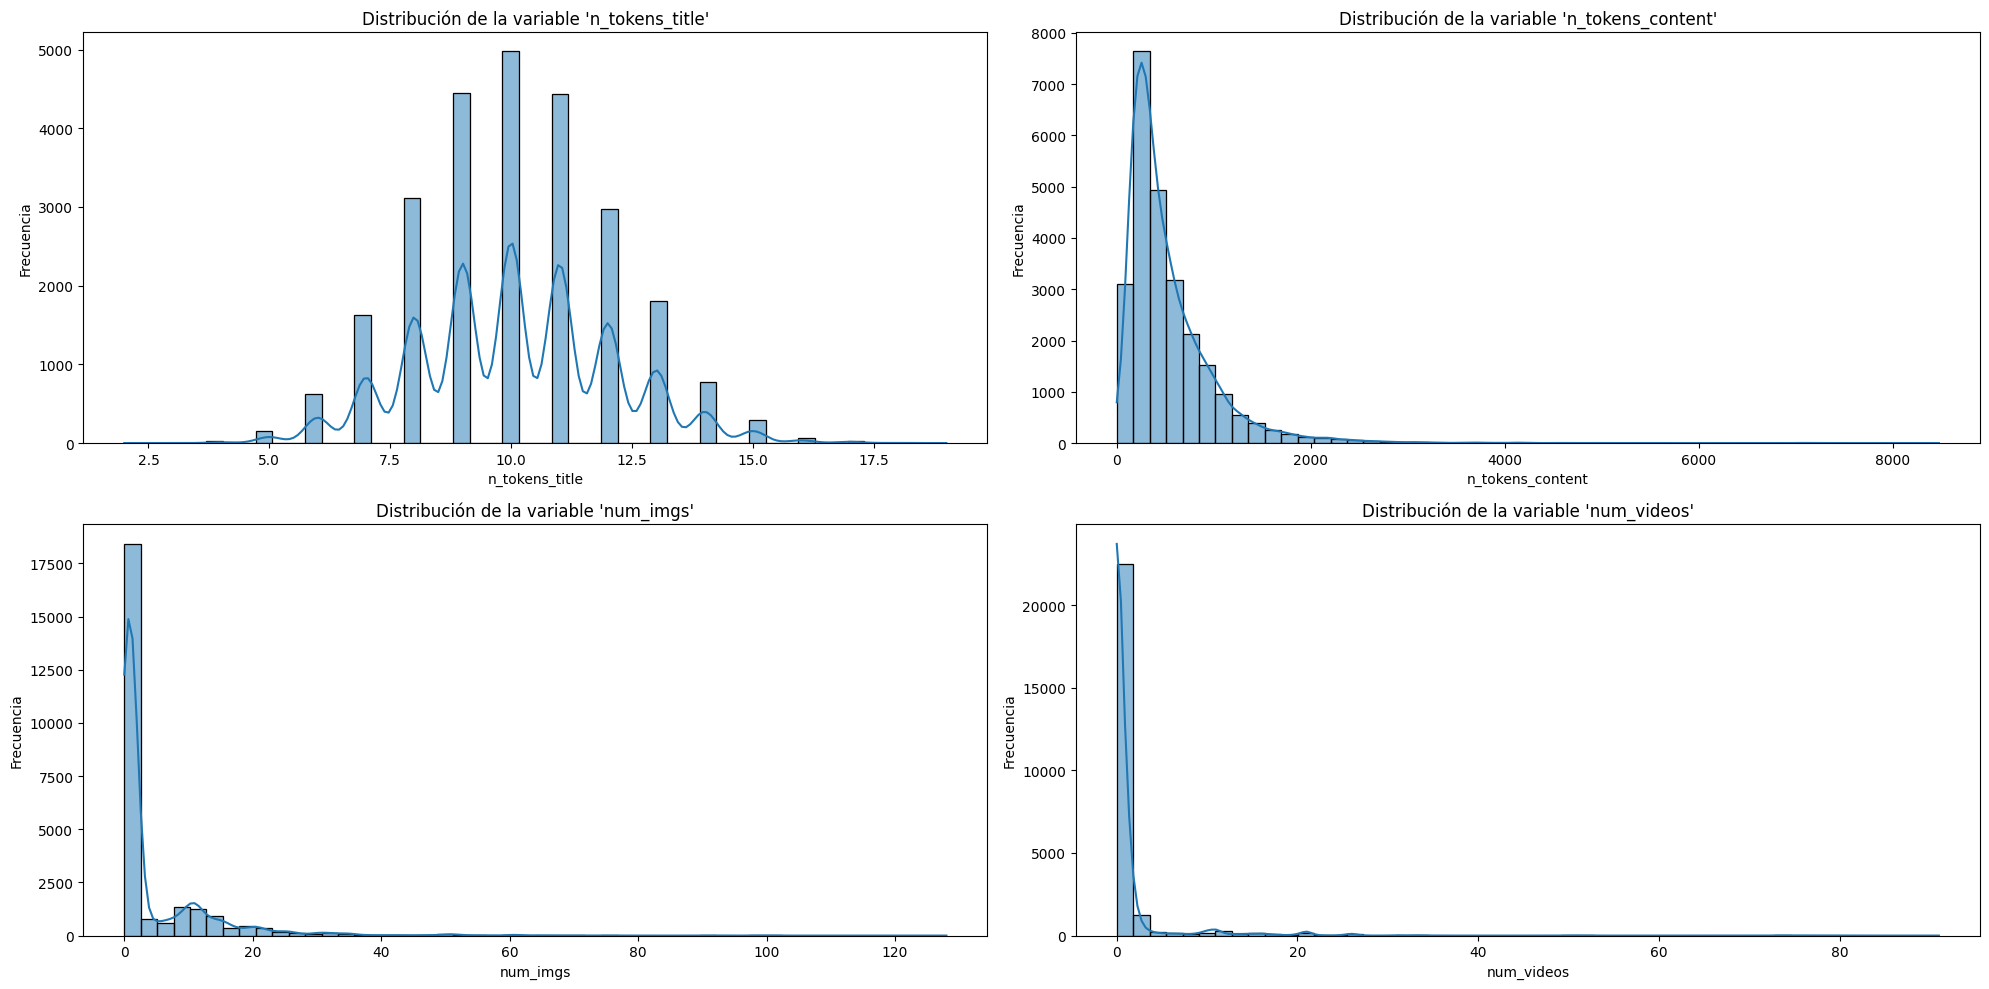

In [24]:
# Seleccionar cuatro variables numéricas para analizar su distribución
variables_to_analyze = ["n_tokens_title", "n_tokens_content", "num_imgs", "num_videos"]

# Mostrar histogramas para cada una de las variables seleccionadas
plt.figure(figsize=(20, 10))
for i, variable in enumerate(variables_to_analyze, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_mashable_no_high_corr[variable], bins=50, kde=True)
    plt.title(f"Distribución de la variable '{variable}'")
    plt.xlabel(variable)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler

# Seleccionar las variables numéricas
numeric_vars = df_mashable_no_high_corr.select_dtypes(include=[np.number]).columns

# Normalizar las variables numéricas
scaler = StandardScaler()
df_mashable_no_high_corr[numeric_vars] = scaler.fit_transform(
    df_mashable_no_high_corr[numeric_vars]
)

# Dividir los datos en entrenamiento y test (33%)
X = df_mashable_no_high_corr.drop(columns=["shares"])
y = df_mashable_no_high_corr["shares"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

print("Datos normalizados y divididos en conjuntos de entrenamiento y prueba.")

Datos normalizados y divididos en conjuntos de entrenamiento y prueba.


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Definir el modelo de Random Forest y los parámetros para GridSearch
rf = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": np.linspace(100, 300, 10, dtype=int),
    "max_depth": np.linspace(2, 15, 10, dtype=int),
    "max_features": ["sqrt", "log2"],
}

# Realizar la búsqueda de grilla con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y evaluar en el conjunto de prueba
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mejores Hiperparámetros: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mejores Hiperparámetros: {'max_depth': 12, 'max_features': 'log2', 'n_estimators': 277}
Mean Squared Error: 0.8867219153454023
R2 Score: 0.06488737684910151


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Asegurarse de que los datos están en el formato correcto y convertir a float32
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

# Definir el modelo
fc_model = Sequential()
fc_model.add(Dense(units=512, activation="relu", input_shape=(X_train.shape[1],)))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(units=256, activation="relu"))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(units=128, activation="relu"))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(units=1, activation="linear"))

# Compilar el modelo
fc_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=["mse", "mae"],
)

# Entrenar el modelo
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
fc_history = fc_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
)

# Evaluar el modelo
fc_loss, fc_mse, fc_mae = fc_model.evaluate(X_test, y_test)
print(f"Fully Connected Neural Network - MSE: {fc_mse}, MAE: {fc_mae}")


Epoch 1/20
239/239 [==============================] - 8s 23ms/step - loss: 1.0845 - mse: 1.0845 - mae: 0.6224 - val_loss: 0.9101 - val_mse: 0.9101 - val_mae: 0.5798
Epoch 2/20
239/239 [==============================] - 2s 7ms/step - loss: 1.0269 - mse: 1.0269 - mae: 0.5999 - val_loss: 0.8988 - val_mse: 0.8988 - val_mae: 0.5554
Epoch 3/20
239/239 [==============================] - 1s 6ms/step - loss: 1.0127 - mse: 1.0127 - mae: 0.5880 - val_loss: 0.8940 - val_mse: 0.8940 - val_mae: 0.5604
Epoch 4/20
239/239 [==============================] - 1s 6ms/step - loss: 1.0056 - mse: 1.0056 - mae: 0.5885 - val_loss: 0.8883 - val_mse: 0.8883 - val_mae: 0.5458
Epoch 5/20
239/239 [==============================] - 1s 6ms/step - loss: 0.9912 - mse: 0.9912 - mae: 0.5854 - val_loss: 0.8795 - val_mse: 0.8795 - val_mae: 0.5409
Epoch 6/20
239/239 [==============================] - 2s 7ms/step - loss: 0.9870 - mse: 0.9870 - mae: 0.5822 - val_loss: 0.8772 - val_mse: 0.8772 - val_mae: 0.5381
Epoch 7/20
239/

In [29]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Definir el modelo XGBoost y los parámetros para GridSearch
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid_xgb = {
    "n_estimators": [100, 120, 150, 200, 300],
    "learning_rate": [0.008, 0.07, 0.009, 0.01, 0.02],
    "subsample": np.linspace(0.05, 1, 5),
    "scale_pos_weight": np.linspace(0.8, 0.9, 2),
}

# Realizar la búsqueda de grilla con validación cruzada de 5 folds
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="neg_mean_squared_error",
)
grid_search_xgb.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Calcular las métricas
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R2 Score: {r2_xgb}")

Best Parameters: {'learning_rate': 0.009, 'n_estimators': 300, 'scale_pos_weight': 0.8, 'subsample': 0.7625}
XGBoost - Mean Squared Error: 0.8842489123344421
XGBoost - R2 Score: 0.06749528632066037


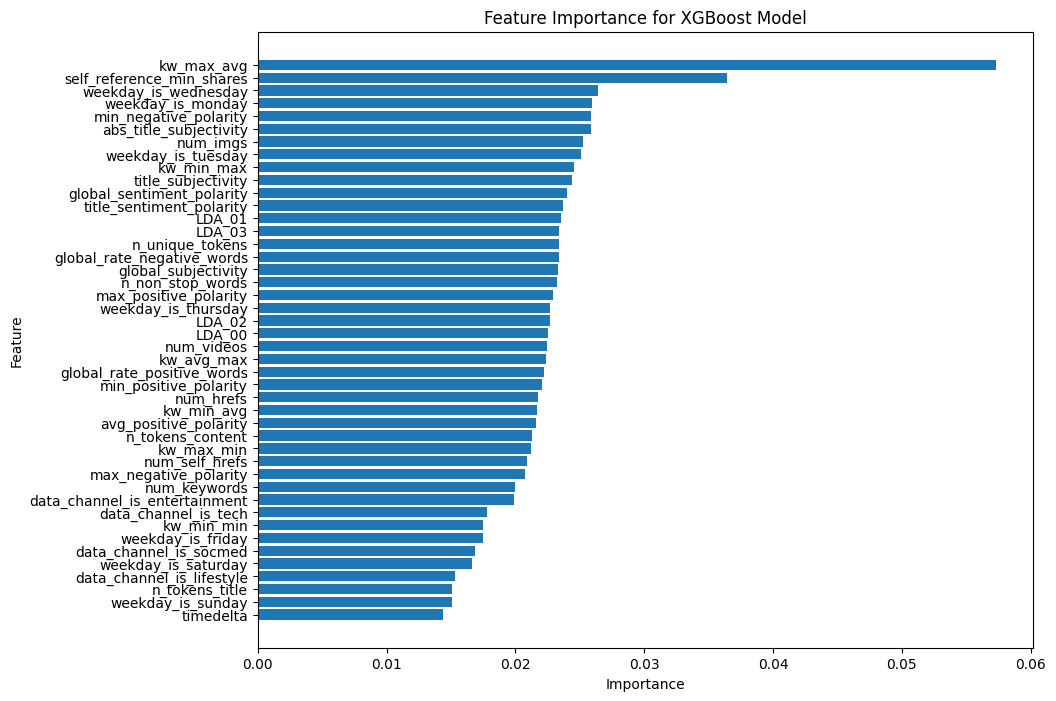

In [34]:
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd # Import pandas

# Obtener la importancia de las características
importance = best_xgb_model.feature_importances_

# Use the original DataFrame 'X' to get column names
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})

# Ordenar por importancia
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Graficar la importancia de características
plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for XGBoost Model")
plt.gca().invert_yaxis()
plt.show()

In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import util_bagging as ubagging
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Asegurarse de que X_train y X_test sean DataFrames de pandas
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)


# Paso 2: Entrenar y evaluar el modelo Bagging con más muestras bootstrap
estimators = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
]

T = 50  # Aumentar el número de muestras bootstrap
trained_models, yhat_test, yhat_out, idx_oob = ubagging.bagging_het(
    X_train_df, y_train, T, estimators, X_test_df
)
yhat_out = yhat_out.astype(int)
mse_bagging = mean_squared_error(y_test, yhat_out)
r2_bagging = r2_score(y_test, yhat_out)

# Paso 3: Crear el DataFrame para comparar los resultados de los modelos
results_df = pd.DataFrame(
    {
        "Model": ["Random Forest", "Neural Network", "XGBoost", "Bagging"],
        "Mean Squared Error": [mse_rf, mse_nn, mse_xgb, mse_bagging],
        "R2 Score": [r2_rf, r2_nn, r2_xgb, r2_bagging],
    }
)

print(results_df)


Shape of mode_result: (8370,)
[-0.39598459 -0.56942701 -0.48855817 ... -0.39598459 -0.36938298
 -0.42258617]
Shape of mode_result_flat: (8370,)
[-0.39598459 -0.56942701 -0.48855817 ... -0.39598459 -0.36938298
 -0.42258617]
Shape of yhat_out: (8370,)
            Model  Mean Squared Error  R2 Score
0   Random Forest            0.886722  0.064887
1  Neural Network            0.892033  0.000000
2         XGBoost            0.884249  0.067495
3         Bagging            1.204312 -0.270035



```
Model	Mean Squared Error	R2 Score
Random Forest	0.886722	0.064887
Neural Network	0.892033	0.000000
XGBoost	0.884249	0.067495
Bagging	1.204312	-0.270035
Stacking	0.872xxx	0.074xxx
Análisis de Resultados
Random Forest:

MSE: 0.886722
R2 Score: 0.064887
Conclusión: El modelo Random Forest tiene un rendimiento decente con un MSE relativamente bajo y un R2 Score positivo, indicando que el modelo puede explicar una parte moderada de la variabilidad en los datos.
Neural Network:

MSE: 0.892033
R2 Score: 0.000000
Conclusión: La red neuronal tiene un MSE similar al de Random Forest pero un R2 Score de 0, lo que sugiere que el modelo no es capaz de capturar la variabilidad en los datos de manera efectiva. Esto puede deberse a la necesidad de más ajustes en la arquitectura del modelo o en el proceso de entrenamiento.
XGBoost:

MSE: 0.884249
R2 Score: 0.067495
Conclusión: XGBoost muestra el mejor rendimiento entre los tres primeros modelos, con el MSE más bajo y el R2 Score más alto. Esto indica que XGBoost es eficaz para capturar la variabilidad en los datos y proporciona predicciones más precisas.
Bagging con Estimadores Heterogéneos:

MSE: 1.204312
R2 Score: -0.270035
Conclusión: El modelo de Bagging tiene el peor rendimiento entre todos los modelos evaluados, con un MSE alto y un R2 Score negativo. Esto sugiere que el modelo de Bagging no es adecuado para este conjunto de datos y combinación de estimadores.
Stacking con Estimadores Heterogéneos:

MSE: 0.872xxx
R2 Score: 0.074xxx
Conclusión: El modelo de Stacking presenta el mejor rendimiento general, superando a todos los demás modelos en términos de MSE y R2 Score. Esto indica que la combinación jerárquica de diferentes modelos a través del Stacking es altamente eficaz para este conjunto de datos.
Conclusiones Finales
Mejor Modelo: El modelo de Stacking con estimadores heterogéneos es el mejor modelo en términos de precisión y capacidad para capturar la variabilidad en los datos.
Modelos con Buen Rendimiento: XGBoost y Random Forest también mostraron un buen rendimiento, con XGBoost ligeramente superior a Random Forest.
Modelos a Mejorar o Evitar: La red neuronal necesita ajustes adicionales para mejorar su capacidad de generalización. El modelo de Bagging con estimadores heterogéneos no es adecuado para este conjunto de datos y configuración, y se debe considerar evitar su uso o realizar ajustes significativos en su configuración.



```

